In [2]:
import os, sys, glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import loompy
import logging

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [190]:
samples = np.array(['232_1', '232_2', '232_3', '232_4', '242_1', '242_2', '242_3',
                   '242_4', '250_1', '250_2', '250_3', '250_4', '279_1', '279_2',
                   '279_3', '280_1', '280_2', '280_3', '286_1', '286_2', '286_7',
                   '286_8', '290_1', '290_2', '291_2', '291_3', '309_1', '312_1',
                   '312_2', '312_3', '312_4', '312_5', '312_6', '313_1', '313_2',
                   '313_3', '313_4', '313_5', '313_6', '315_1', '315_2', '315_3',
                   '315_4', '315_5', '315_6', '315_7', '315_8', '316_1', '316_3',
                   '316_4', '316_5', '316_6', '317_1', '317_3', '317_4', '317_5',
                   '317_6', '320_1', '321_1', '321_2', '321_3', '321_4', '321_5',
                   '321_6', '322_1', '324_1', '324_2', '325_1', '325_2', '325_3',
                   '325_4', '325_6', '328_1', '332_1', '333_1', '335_1', '339_1',
                   '340_1', '340_2', '340_3', '340_4', '345_1', '345_2', '345_3',
                   '345_4', '346_1', '346_2', '346_3', '346_4', '347_1', '347_2',
                   '347_3', '347_4', '364_2', '364_4', '365_2', '365_4', '367_1',
                   '368_1', '368_2', '370_1', '370_2', '370_3', '370_4', '400_1',
                   '400_2', '400_3', '400_4', '400_6', '400_7', '400_8', '402_1',
                   '402_2'])

array(['232_1', '232_2', '232_3', '232_4', '242_1', '242_2', '242_3',
       '242_4', '250_1', '250_2', '250_3', '250_4', '279_1', '279_2',
       '279_3', '280_1', '280_2', '280_3', '286_1', '286_2', '286_7',
       '286_8', '290_1', '290_2', '291_2', '291_3', '309_1', '312_1',
       '312_2', '312_3', '312_4', '312_5', '312_6', '313_1', '313_2',
       '313_3', '313_4', '313_5', '313_6', '315_1', '315_2', '315_3',
       '315_4', '315_5', '315_6', '315_7', '315_8', '316_1', '316_3',
       '316_4', '316_5', '316_6', '317_1', '317_3', '317_4', '317_5',
       '317_6', '320_1', '321_1', '321_2', '321_3', '321_4', '321_5',
       '321_6', '322_1', '324_1', '324_2', '325_1', '325_2', '325_3',
       '325_4', '325_6', '328_1', '332_1', '333_1', '335_1', '339_1',
       '340_1', '340_2', '340_3', '340_4', '345_1', '345_2', '345_3',
       '345_4', '346_1', '346_2', '346_3', '346_4', '347_1', '347_2',
       '347_3', '347_4', '364_2', '364_4', '365_2', '365_4', '367_1',
       '368_1', '368

In [215]:
def get_metadata(cell_ranger, sample, verbose:bool=False):
    dirs = glob.glob(f'{cell_ranger}/{sample}*')
    if len(dirs) > 0:
        dirs = np.array([d for d in dirs if os.path.isdir(d)])
        dirs = dirs[[len(d.split('_')) == 4 for d in dirs]]
        n_flowcells = [len(d.split('_')[-2]) for d in dirs]
        if len(dirs) > 1:
            dirs = np.array(dirs)[np.where(n_flowcells==np.max(n_flowcells))[0]]
            ID = [int(d.split('_')[-1]) for d in dirs]
            indir = dirs[np.where(ID==np.max(ID))[0]][0]
        else:
            indir = dirs[0]
        if verbose:
            logging.info(f'Using cellranger output: {indir}')
        
#         fs = glob.glob(os.path.join(indir, 'outs/summary*'))
        fs = os.path.join(indir, 'outs/summary.csv')
        data = pd.read_csv(fs)
        if verbose:
            logging.info(data.shape)
        return data
    

In [92]:
X = [get_metadata('/data/proj/chromium', f'10X{s}') for s in samples]

In [93]:
ATAC_summary = []
ARC_summary = []

for id, meta in zip(samples, X):
    s = '_'.join(meta['Sample ID'][0].split('_')[:2])
    m = load_sample_metadata(path_meta, s)
    
    for k in ['Shortname', 'Project', 'Age', 'Tissue', 'Chemistry']:
        meta[k] = m[k]
    if 'arc' in meta['Pipeline version'][0]:
        ARC_summary.append(meta)
    else:
        ATAC_summary.append(meta)
        
ARC_summary = pd.concat(ARC_summary)
ATAC_summary = pd.concat(ATAC_summary)

In [186]:
v = (ATAC_summary['Median high-quality fragments per cell'] <= 15000) & (ATAC_summary['Percent duplicates'] <= 0.5)
# ATAC_samples = ['_'.join(x.split('_')[:2]) for x in ATAC_summary.loc[v, 'Sample ID']]
ATAC_samples = [x for x in ATAC_summary.loc[v, 'Sample ID']]
# print(ATAC_summary.loc[v, ['Sample ID', 'Median high-quality fragments per cell', 'Percent duplicates']])

v = (ARC_summary['ATAC Median high-quality fragments per cell'] <= 15000) & (ARC_summary['ATAC Percent duplicates'] <= 0.5)
# ARC_samples = ['_'.join(x.split('_')[:2]) for x in ARC_summary.loc[v, 'Sample ID']]
ARC_samples = [x for x in ARC_summary.loc[v, 'Sample ID']]
# print(ARC_summary.loc[v, ['Sample ID', 'ATAC Median high-quality fragments per cell', 'ATAC Percent duplicates']])

print(ATAC_samples)

print(ARC_samples)

['10X242_3_AB_2', '10X250_3_AB_2', '10X250_4_AB_2', '10X279_1_AB_3', '10X279_2_AB_3', '10X286_7_AB_3', '10X286_8_AB_3', '10X313_6_AB_2', '10X316_3_AB_2', '10X321_1_AB_2', '10X321_4_AB_2', '10X328_1_AB_2', '10X339_1_AB_2', '10X340_3_AB_2', '10X345_3_AB_2', '10X345_4_AB_2', '10X347_2_AB_2']
['10X333_1_ABCD_3', '10X335_1_ABCD_2', '10X367_1_ABCD_1', '10X368_1_ABCD_1', '10X370_3_ABCD_1', '10X400_7_ABCD_2']


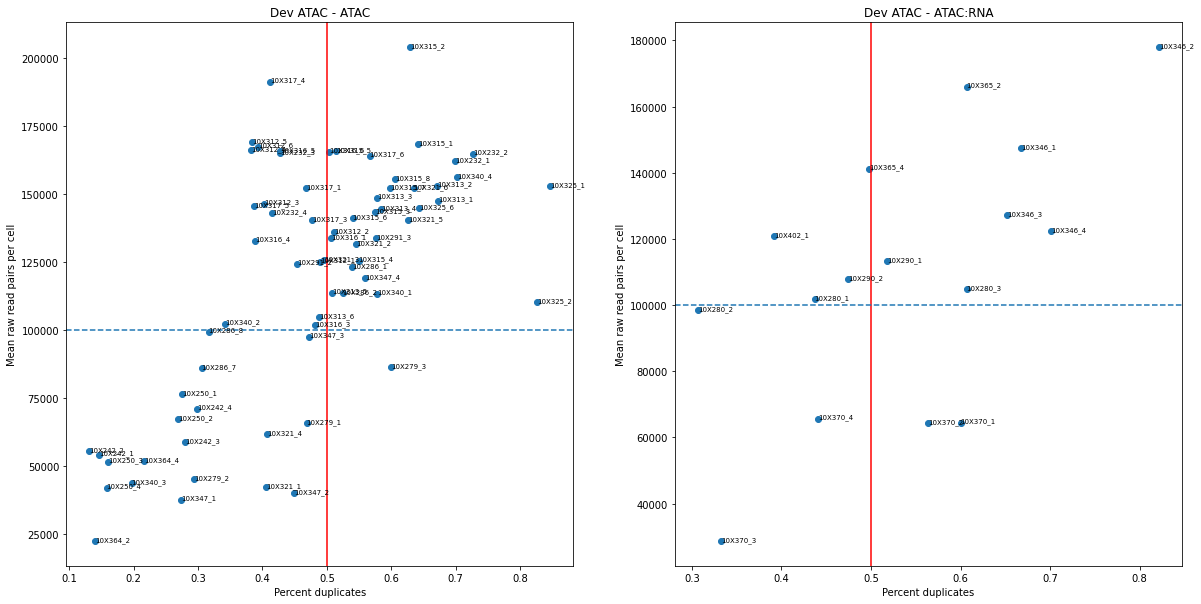

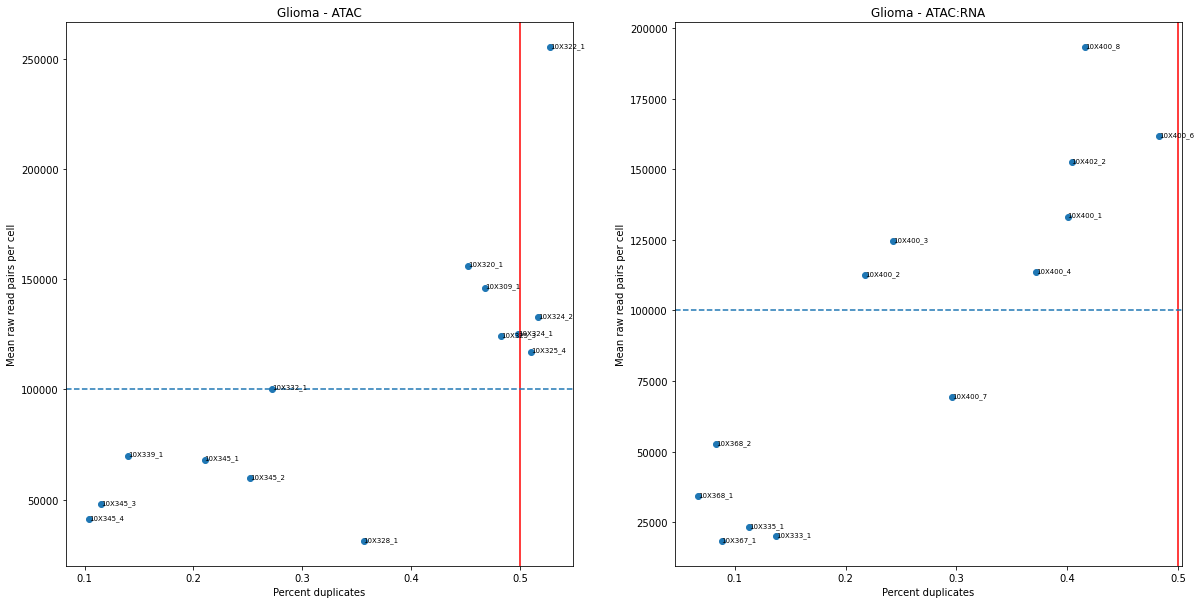

In [188]:
for project in ['Dev ATAC', 'Glioma']:
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    valid = ATAC_summary['Project']==project

    ## ATAC
    # xv = np.log10(ATAC_summary['Estimated bulk library complexity'])
    # yv = np.log10(ATAC_summary['Estimated number of cells'])
    xv = ATAC_summary.loc[valid,'Percent duplicates']
    yv = ATAC_summary.loc[valid,'Mean raw read pairs per cell']
    ax[0].scatter(xv, yv);
    # ax[0].set_xlabel('log10 library complexity');
    ax[0].set_xlabel('Percent duplicates');
    ax[0].set_ylabel('Mean raw read pairs per cell');
    ax[0].axvline(.5, c='red')
    ax[0].axhline(100000, linestyle='--')
    ax[0].set_title(f'{project} - ATAC')
    for x, y, label in zip(xv, yv, ATAC_summary.loc[valid,'Sample ID']):
        ax[0].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)

    ## ARC
    valid = ARC_summary['Project']==project
    xv = ARC_summary.loc[valid,'ATAC Percent duplicates']
    yv = ARC_summary.loc[valid,'ATAC Mean raw read pairs per cell']
    # yv = np.log10(ARC_summary['Estimated number of cells'])
    ax[1].scatter(xv, yv);
    ax[1].set_xlabel('Percent duplicates');
    ax[1].set_ylabel('Mean raw read pairs per cell');
    ax[1].axvline(.5, c='red')
    ax[1].axhline(100000, linestyle='--')
    ax[1].set_title(f'{project} - ATAC:RNA')
    for x, y, label in zip(xv, yv, ARC_summary.loc[valid,'Sample ID']):
        ax[1].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)

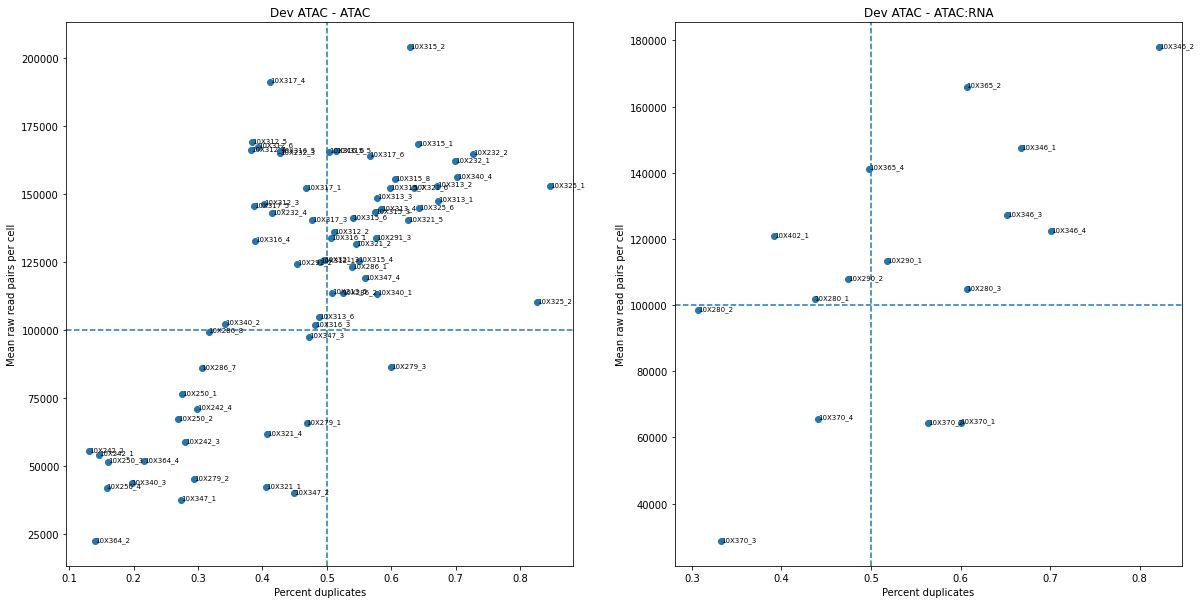

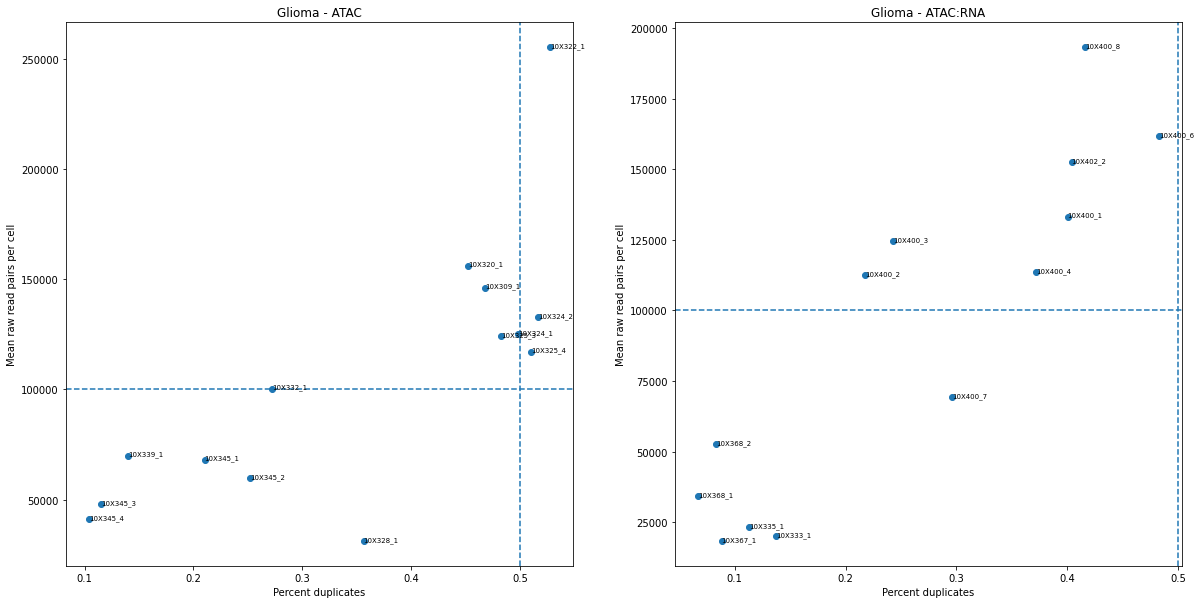

In [183]:
for project in ['Dev ATAC', 'Glioma']:
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    ## ATAC
    valid = ATAC_summary['Project']==project
    xv = ATAC_summary.loc[valid,'Percent duplicates']
    yv = ATAC_summary.loc[valid,'Mean raw read pairs per cell']
    ax[0].scatter(xv, yv);
    ax[0].set_xlabel('Percent duplicates');
    ax[0].set_ylabel('Mean raw read pairs per cell');
    ax[0].axhline(100000, linestyle='--')
    ax[0].axvline(.5, linestyle='--')
    ax[0].set_title(f'{project} - ATAC')
    for x, y, label in zip(xv, yv, ATAC_summary.loc[valid,'Sample ID']):
        ax[0].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)

    ## ARC
    valid = ARC_summary['Project']==project
    xv = ARC_summary.loc[valid,'ATAC Percent duplicates']
    yv = ARC_summary.loc[valid,'ATAC Mean raw read pairs per cell']
    ax[1].scatter(xv, yv);
    ax[1].set_xlabel('Percent duplicates');
    ax[1].set_ylabel('Mean raw read pairs per cell');
    ax[1].axhline(100000, linestyle='--')
    ax[1].axvline(.5, linestyle='--')
    ax[1].set_title(f'{project} - ATAC:RNA')
    for x, y, label in zip(xv, yv, ARC_summary.loc[valid,'Sample ID']):
        ax[1].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)

15:51:59 INFO     ['10X242_3_AB_2', '10X250_3_AB_2', '10X250_4_AB_2', '10X279_1_AB_3', '10X279_2_AB_3', '10X286_7_AB_3', '10X286_8_AB_3', '10X313_5_AB_2', '10X313_6_AB_2', '10X316_3_AB_2', '10X321_1_AB_2', '10X321_4_AB_2', '10X325_1_AB_2', '10X325_2_AB_2', '10X340_3_AB_2', '10X347_2_AB_2']
15:51:59 INFO     ['10X328_1_AB_2', '10X339_1_AB_2', '10X345_3_AB_2', '10X345_4_AB_2']


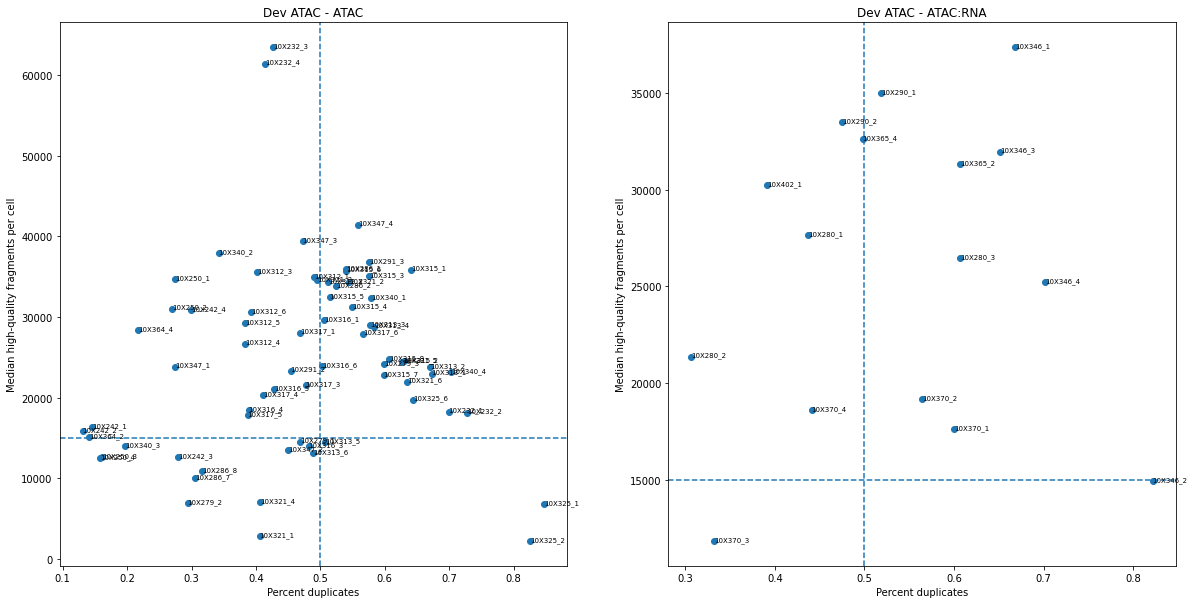

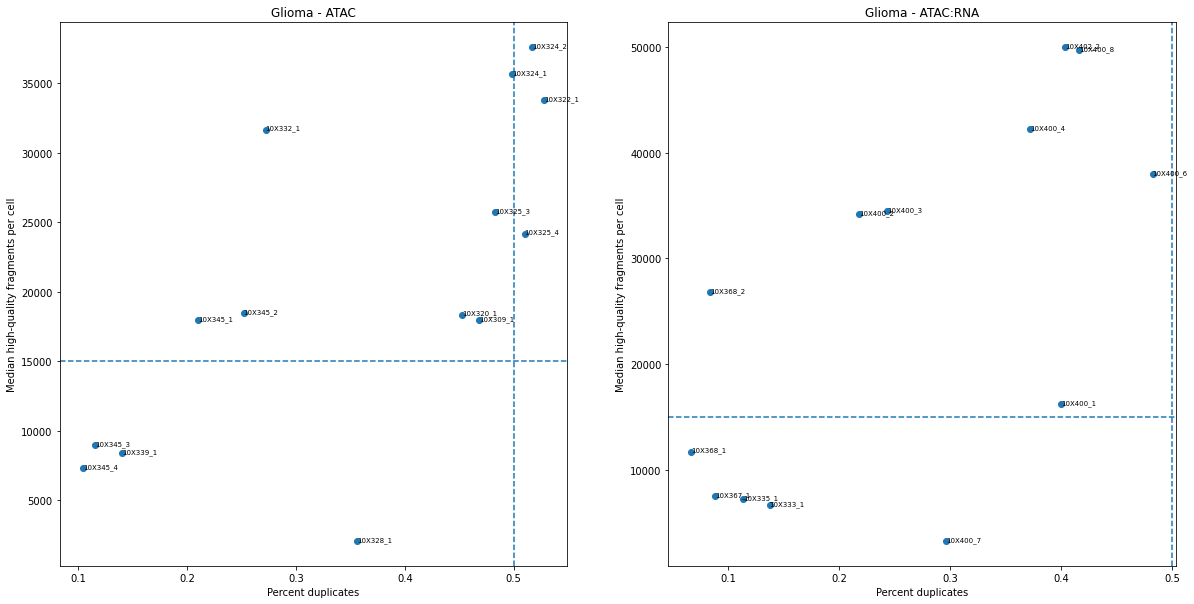

In [184]:
for project in ['Dev ATAC', 'Glioma']:
    fig, ax = plt.subplots(1,2, figsize=(20,10))

    ## ATAC
    valid = ATAC_summary['Project']==project
    xv = ATAC_summary.loc[valid,'Percent duplicates']
    yv = ATAC_summary.loc[valid,'Median high-quality fragments per cell']
    ax[0].scatter(xv, yv);
    ax[0].set_xlabel('Percent duplicates');
    ax[0].set_ylabel('Median high-quality fragments per cell');
    ax[0].axhline(15000, linestyle='--')
    ax[0].axvline(.5, linestyle='--')
    ax[0].set_title(f'{project} - ATAC')
    for x, y, label in zip(xv, yv, ATAC_summary.loc[valid,'Sample ID']):
        ax[0].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)
        
    undersampled = []
    for label, v in zip(ATAC_summary.loc[valid,'Sample ID'], yv):
        if v < 15000:
            undersampled.append(label)
    logging.info(undersampled)

    ## ARC
    valid = ARC_summary['Project']==project
    xv = ARC_summary.loc[valid,'ATAC Percent duplicates']
    yv = ARC_summary.loc[valid,'ATAC Median high-quality fragments per cell']
    ax[1].scatter(xv, yv);
    ax[1].set_xlabel('Percent duplicates');
    ax[1].set_ylabel('Median high-quality fragments per cell');
    ax[1].axhline(15000, linestyle='--')
    ax[1].axvline(.5, linestyle='--')
    ax[1].set_title(f'{project} - ATAC:RNA')
    for x, y, label in zip(xv, yv, ARC_summary.loc[valid,'Sample ID']):
        ax[1].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)

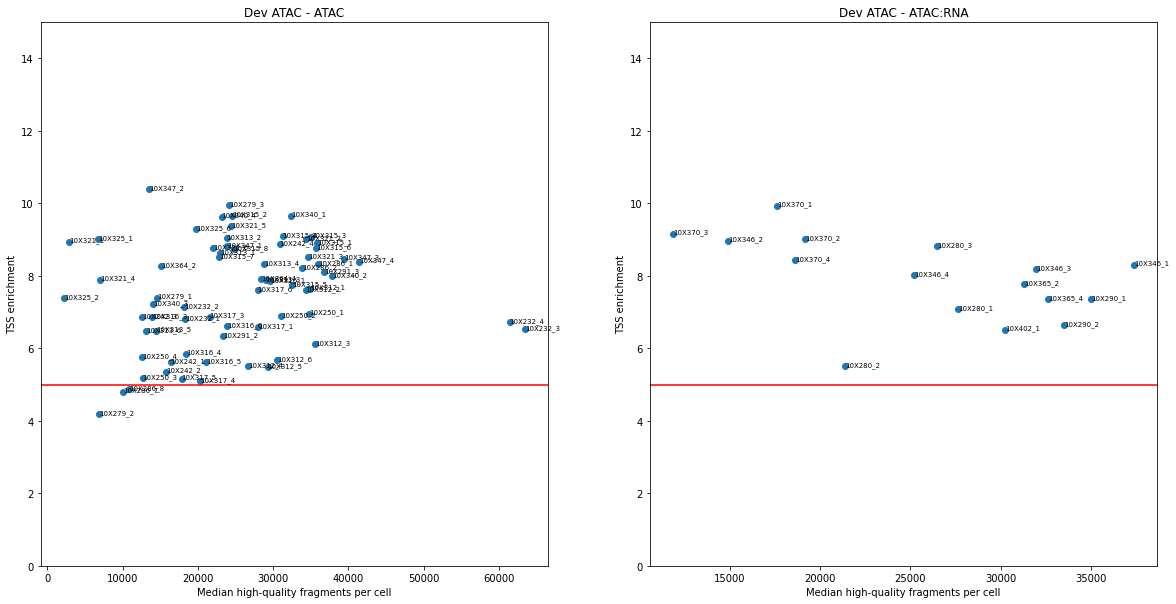

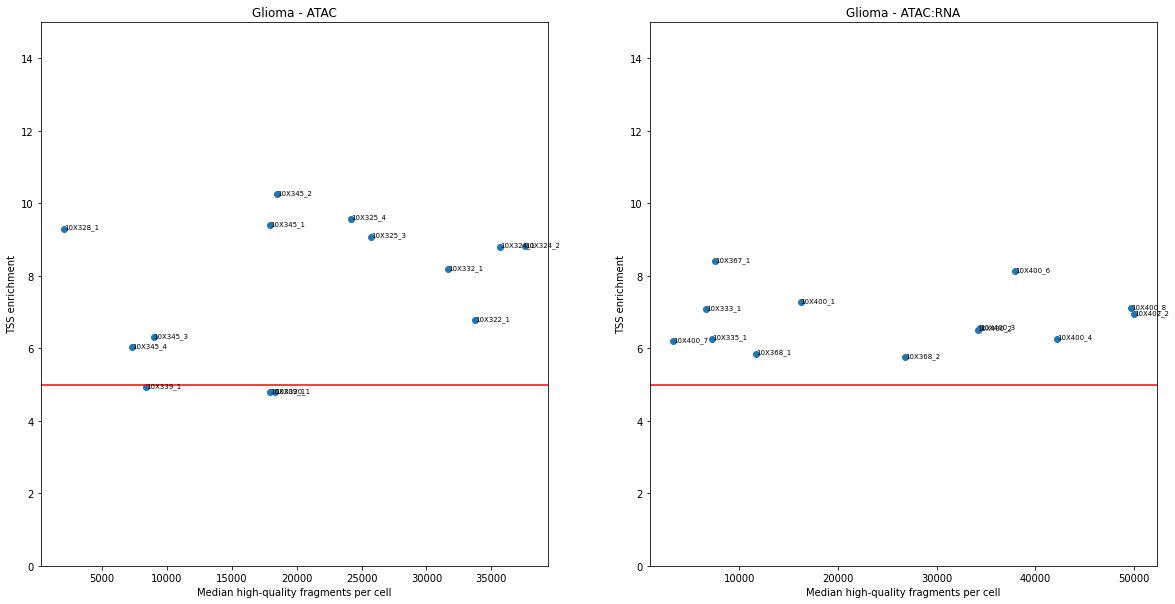

In [142]:
for project in ['Dev ATAC', 'Glioma']:
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    ## ATAC
    valid = ATAC_summary['Project']==project
    xv = ATAC_summary.loc[valid,'Median high-quality fragments per cell']
    yv = ATAC_summary.loc[valid,'TSS enrichment score']
    ax[0].scatter(xv, yv);
    ax[0].set_ylim(0,15);
    ax[0].set_xlabel('Median high-quality fragments per cell');
    ax[0].set_ylabel('TSS enrichment');
    ax[0].axhline(5, c='red')
    ax[0].set_title(f'{project} - ATAC')
    for x, y, label in zip(xv, yv, ATAC_summary.loc[valid,'Sample ID']):
        ax[0].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)

    ## ARC
    valid = ARC_summary['Project']==project
    xv = ARC_summary.loc[valid,'ATAC Median high-quality fragments per cell']
    yv = ARC_summary.loc[valid,'ATAC TSS enrichment score']
    ax[1].scatter(xv, yv);
    ax[1].set_ylim(0,15);
    ax[1].set_xlabel('Median high-quality fragments per cell');
    ax[1].set_ylabel('TSS enrichment');
    ax[1].axhline(5, c='red')
    ax[1].set_title(f'{project} - ATAC:RNA')
    for x, y, label in zip(xv, yv, ARC_summary.loc[valid,'Sample ID']):
        ax[1].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)

In [265]:
def get_metadata(cell_ranger, sample, verbose:bool=False):
    dirs = glob.glob(f'{cell_ranger}/{sample}*')
    if len(dirs) > 0:
        dirs = np.array([d for d in dirs if os.path.isdir(d)])
#         dirs = dirs[[len(d.split('_')) == 4 for d in dirs]]
        n_flowcells = [len(d.split('_')[-2]) for d in dirs]
        if len(dirs) > 1:
            dirs = np.array(dirs)[np.where(n_flowcells==np.max(n_flowcells))[0]]
            ID = [int(d.split('_')[-1]) for d in dirs]
            indir = dirs[np.where(ID==np.max(ID))[0]][0]
        else:
            indir = dirs[0]
        if verbose:
            logging.info(f'Using cellranger output: {indir}')
        
#         fs = glob.glob(os.path.join(indir, 'outs/summary*'))
        fs = os.path.join(indir, 'outs/summary.csv')
        if os.path.isfile(fs):
            data = pd.read_csv(fs)
            if verbose:
                logging.info(data.shape)
            return data
        else:
            return False
    

In [266]:
d = '/datb/sl/analysis/atac-ihf'
samples = os.listdir(d)
samples = [x for x in samples if os.path.isdir(os.path.join(d,x))]
samples = [x.split('10X')[-1] for x in samples]
X = [get_metadata('/datb/sl/analysis/atac-ihf', f'10X{s}') for s in samples]

filtered_summary = []

for meta in X:
    try:
        s = '_'.join(meta['Sample ID'][0].split('_')[:2])
        m = load_sample_metadata(path_meta, s)

        for k in ['Shortname', 'Project', 'Age', 'Tissue', 'Chemistry']:
            meta[k] = m[k]
        filtered_summary.append(meta)
    except:
        continue
        
filtered_summary = pd.concat(filtered_summary)

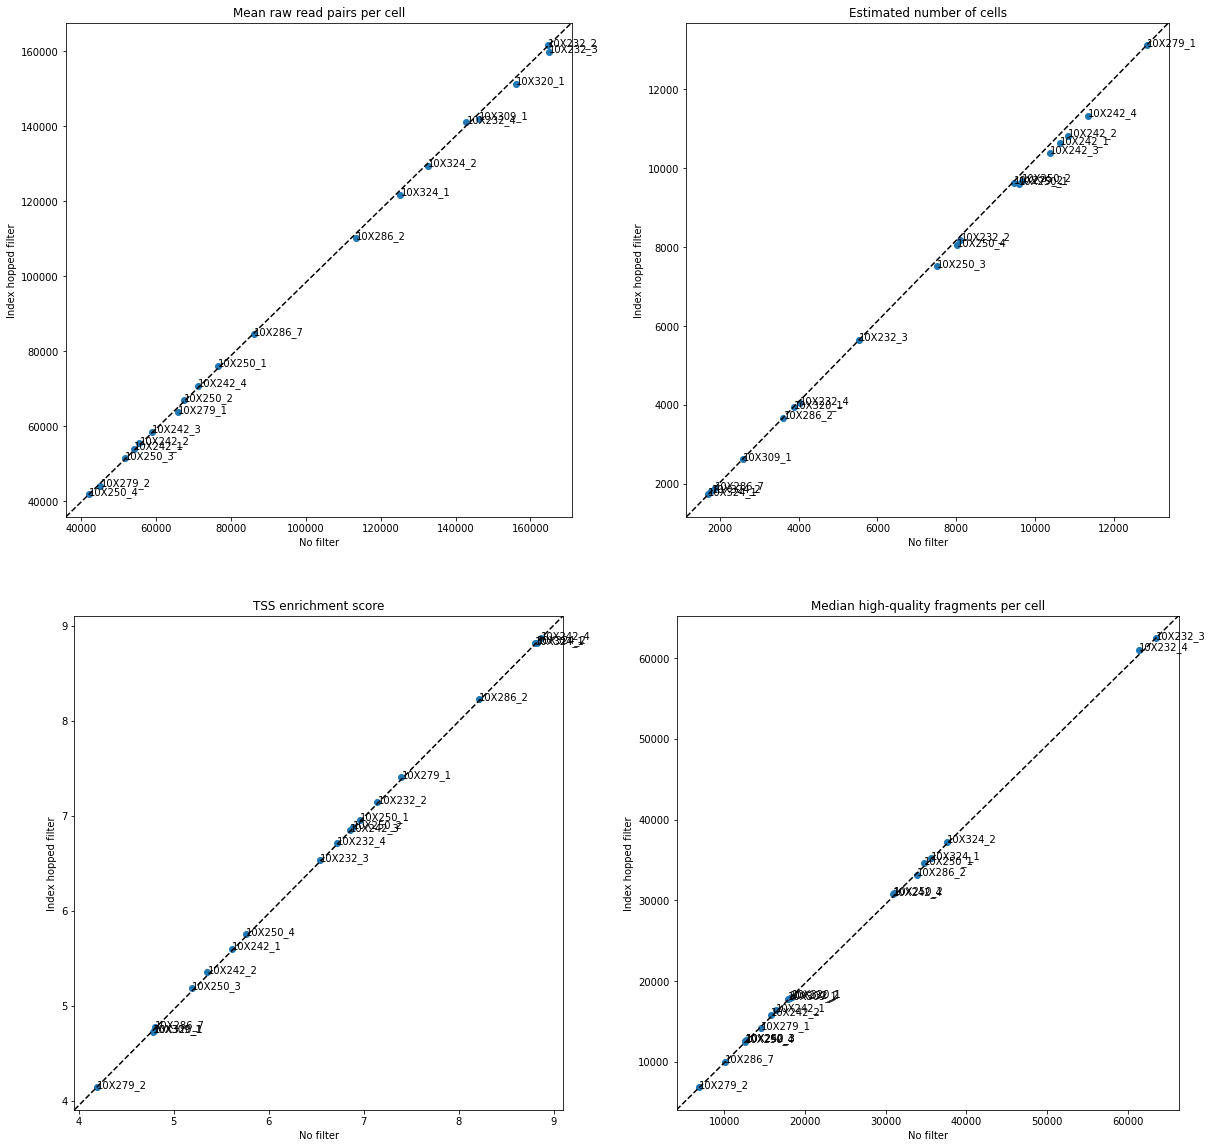

In [367]:
metrics = ['Mean raw read pairs per cell', 'Estimated number of cells', 'TSS enrichment score', 'Median high-quality fragments per cell']

fig, ax = plt.subplots(2,2, figsize=(20,20))
ax = ax.flatten()

for i, m in enumerate(metrics):
    xv = []
    yv = []
    ids = []
    ATAC_IDs = np.array(['_'.join(x.split('_')[:2]) for x in ATAC_summary['Sample ID']])

    for id in filtered_summary['Sample ID']:
        s = [x == id for x in ATAC_IDs]
        if np.sum(s) > 0:
            ids.append(id)
            yv.append(filtered_summary.loc[filtered_summary['Sample ID']==id, m][0])
            xv.append(ATAC_summary.loc[s, m][0])

    ax[i].scatter(xv, yv);
    ax[i].plot([0, 1], [0, 1], transform=ax[i].transAxes, c='black', linestyle='--')
    ax[i].set_xlabel('No filter');
    ax[i].set_ylabel('Index hopped filter');
    ax[i].set_aspect('equal')
    ax[i].set_title(m)
    for x, y, label in zip(xv, yv, ids):
    #     ax[0].annotate('_'.join(label.split('_')[:2]), xy=(x, y), fontsize=7)
        ax[i].annotate(label, xy=(x, y))
plt.savefig('/home/camiel/misc/ihf_figs.png')

(array([ 0.,  0.,  0.,  2., 17.,  0.,  0.,  0.,  0.,  0.]),
 array([0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 ]),
 <BarContainer object of 10 artists>)

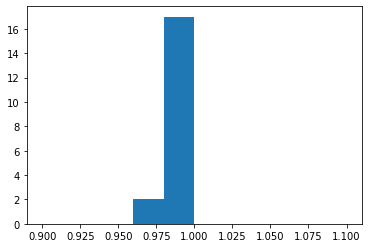

In [365]:
metrics = 'Mean raw read pairs per cell'
xv = []
yv = []
ids = []
ATAC_IDs = np.array(['_'.join(x.split('_')[:2]) for x in ATAC_summary['Sample ID']])

for id in filtered_summary['Sample ID']:
    s = [x == id for x in ATAC_IDs]
    if np.sum(s) > 0:
        ids.append(id)
        yv.append(filtered_summary.loc[filtered_summary['Sample ID']==id, m][0])
        xv.append(ATAC_summary.loc[s, m][0])

X = np.array(yv)/np.array(xv)
plt.hist(X.flatten(), range=(.9,1.1))

8.360988259530052e-05
0.001521944948677165


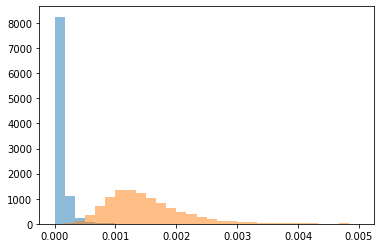

In [369]:
with loompy.connect('/datb/sl/camiel/scATAC/samples/10X232_1/10X232_1_20kb.loom') as ds:
    plt.hist(ds.ca.Y, range=(0,0.005), alpha=.5, bins=30)
    print(np.mean(ds.ca.Y))
    
with loompy.connect('/datb/sl/camiel/scATAC/samples/10X242_1/10X242_1_20kb.loom') as ds:
    plt.hist(ds.ca.Y, range=(0,0.005), alpha=.5, bins=30)   
    print(np.mean(ds.ca.Y))